In [37]:
import asyncio

import nest_asyncio
nest_asyncio.apply()

import pandas as pd
import json
import os
import openai
import matplotlib.pyplot as plt
import base64
import io

from typing import Union, Dict, Optional, Any, List, Tuple, Sequence, Literal
from PIL import Image
from time import time

from llama_index import SimpleDirectoryReader

from llama_index.schema import ImageDocument
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.multi_modal_llms.base import ChatMessage
from llama_index.core.llms.types import ChatResponse
from tqdm import tqdm

In [31]:
MAIN_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(MAIN_DIR, "data")
ARTIFACT_DIR = os.path.join(MAIN_DIR, "artifacts")
DATABASE_DIR = os.path.join(DATA_DIR, "db")
REFERENCE_DIR = os.path.join(DATA_DIR, "reference")
CONSUMER_DIR = os.path.join(DATA_DIR, "consumer")

with open(os.path.join(MAIN_DIR, "auth", "api_keys.json"), "r") as f:
    api_keys = json.load(f)

os.environ["OPENAI_API_KEY"] = api_keys["LEQUAN_OPENAI_KEY"]
openai.api_key = api_keys["LEQUAN_OPENAI_KEY"]

metadata_df = pd.read_csv(os.path.join(DATA_DIR, "exp_metadata_1000.csv"))
master_metadata = json.load(open(os.path.join(DATA_DIR, "metadata", "master_metadata.json")))

all_consumer_images = metadata_df["consumer_1"].tolist() + metadata_df["consumer_2"].tolist() + metadata_df["consumer_3"].tolist() \
                        + metadata_df["consumer_4"].tolist() + metadata_df["consumer_5"].tolist()

all_reference_images = metadata_df["first_reference"].tolist() + metadata_df["second_reference"].tolist()

print("Total Number of consumer images:", len(all_consumer_images))
print("Total Number of reference images:", len(all_reference_images))

# with open(os.path.join(DATA_DIR, "consumer_list_1000.txt"), "w") as f:
#     for image in all_consumer_images:
#         f.write(image + "\n")

# with open(os.path.join(DATA_DIR, "reference_list_1000.txt"), "w") as f:
#     for image in all_reference_images:
#         f.write(image + "\n")

with open(os.path.join(DATA_DIR, "consumer_list_1000.txt"), "r") as f:
    consumer_images = f.readlines()

with open(os.path.join(DATA_DIR, "reference_list_1000.txt"), "r") as f:
    reference_images = f.readlines()

consumer_images = [image.strip() for image in consumer_images]
reference_images = [image.strip() for image in reference_images]

Total Number of consumer images: 5000
Total Number of reference images: 2000


In [8]:
def generate_img_url(image_path: str, resize: Optional[Union[int, Tuple[int, int], Literal["auto"]]] = None):
    encoded_image = encode_image(image_path, resize=resize)
    image_url = f"data:image/jpeg;base64,{encoded_image}"
    return image_url

def resize_with_same_aspect_ratio(height: int, width: int, max_dimension: int = 1024) -> Tuple[int, int]:
    if height < max_dimension and width < max_dimension:
        resize = (height, width)
    elif height > width:
        resize = (512, int(width / (height/512)))
    else:
        resize = (int(height / (width/512)), 512)
    return resize

def encode_image(image_path: str, resize: Optional[Union[int, Tuple[int, int], Literal["auto"]]] = None):
    if resize:
        img = Image.open(image_path)
        h, w = img.size
        if isinstance(resize, int):
            resize = resize_with_same_aspect_ratio(h, w, resize)
        elif resize == "auto":
            resize = resize_with_same_aspect_ratio(h, w, 512)

        resized_img = img.resize(resize)

        # Save the resized image to a buffer
        buffer = io.BytesIO()
        resized_img.save(buffer, format="PNG")
        buffer.seek(0)

        # Encode the resized image to base64
        return base64.b64encode(buffer.getvalue()).decode("utf-8")

    else:
        with open(image_path, "rb") as image_file:
            img_64_str = base64.b64encode(image_file.read()).decode('utf-8')
        return img_64_str

def generate_openai_vision_llamaindex_chat_message(
    prompt: str,
    role: str,
    image_documents: Optional[Sequence[ImageDocument]] = None,
    image_detail: Optional[str] = "high",
    resize: Optional[Union[int, Tuple[int, int], Literal["auto"]]] = None
) -> ChatMessage:
    # if image_documents is empty, return text only chat message
    if image_documents is None:
        return ChatMessage(role=role, content=prompt)

    # if image_documents is not empty, return text with images chat message
    completion_content = [{"type": "text", "text": prompt}]
    for image_document in image_documents:
        image_content: Dict[str, Any] = {}
        mimetype = image_document.image_mimetype or "image/jpeg"
        if image_document.image_path and image_document.image_path != "":
            base64_image = encode_image(image_document.image_path, resize=resize)
            image_content = {
                "type": "image_url",
                "image_url": {
                    "url": f"data:{mimetype};base64,{base64_image}",
                    "detail": image_detail,
                },
            }
        elif (
            "file_path" in image_document.metadata
            and image_document.metadata["file_path"] != ""
        ):
            base64_image = encode_image(image_document.metadata["file_path"], resize=resize)
            image_content = {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}",
                    "detail": image_detail,
                },
            }

        completion_content.append(image_content)
    return ChatMessage(role=role, content=completion_content)

def save_checkpoint(
    ckpt_folder: str,
    img_paths: List[str],
    gpt_raw_answers: List[str],
):
    content = [
        {img_path: gpt_raw_answer for img_path, gpt_raw_answer in zip(img_paths, gpt_raw_answers)}
    ]
    
    if not os.path.exists(ckpt_folder):
        os.makedirs(ckpt_folder, exist_ok=True)
    with open(os.path.join(ckpt_folder, "ckpt.json"), "w") as f:
        json.dump(content, f)
        
def load_checkpoint(
    ckpt_path: str,  
) -> List[Dict]:
    with open(ckpt_path, "r") as f:
        content_list = json.load(f)
    return content_list

def plot_images(images: List[Union[str, ImageDocument]]):
    image_paths = []
    for image in images:
        if isinstance(image, ImageDocument):
            image_paths.append(image.metadata["file_path"])
        elif isinstance(image, str):
            image_paths.append(image)
        else:
            ValueError("Invalid type of image")

    images_shown = 0
    plt.figure(figsize=(8, 8 * len(image_paths)))
    for img_path in image_paths:
        image = Image.open(img_path)

        plt.subplot(1, len(image_paths), images_shown + 1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

        images_shown += 1

In [9]:
sample_images = [
    "PillProjectDisc37/images/BK0UDTM343KHX1I-ANSI_RI-DR_U_6I.JPG",
    "PillProjectDisc110/images/_CNSLF343EJTA_F25S1SJG9-EIKPQ7.JPG",
]

sample_paths = [os.path.join(REFERENCE_DIR, image_file) for image_file in sample_images]
sample_docs = SimpleDirectoryReader(input_files = sample_paths).load_data()
sample_docs

[ImageDocument(id_='879e0556-e89d-44ef-907c-56b34c9a8862', embedding=None, metadata={'file_path': '/mnt/c/Users/QUAN/Desktop/pill/data/reference/PillProjectDisc37/images/BK0UDTM343KHX1I-ANSI_RI-DR_U_6I.JPG', 'file_name': 'BK0UDTM343KHX1I-ANSI_RI-DR_U_6I.JPG', 'file_type': 'image/jpeg', 'file_size': 77886, 'creation_date': '2024-01-30', 'last_modified_date': '2024-01-22', 'last_accessed_date': '2024-01-30'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='/mnt/c/Users/QUAN/Desktop/pill/data/reference/PillProjectDisc37/images/BK0UDTM343KHX1I-ANSI_RI-DR_U_6I.JPG', image_url=None, image_m

# GPT-4V LLM

## Zero-shot prompt

In [10]:
CAPTION_EXTRACTION_PROMPT = (
    "You are given an image of a pill. Extract the relevant visual features from the given image,"
    "including shape, colors, imprint, imprint color, symbols, if any and whether the pill can be broken down into smaller parts.\n"
    "=========\n"
    "OUTPUT INSTRUCTIONS: Each line of the final output should contain description about an individual visual feature of the pill. If the visual characteristics cannot be inferred from the image, return N/A for that features\n"
    "EXAMPLE:\n"
    "Image features of the pill:\n"
    "- Shape: CAPSULE - Has the shape of a capsule when viewing the capsule from a point perpendicular to its longest side. The capsule shape is reserved for two-part capsules and banded two-part capsules.\n"
    "- Color: WHITE\n"
    "- Imprint: Lilly;3227;10;mg\n"
    "- ImprintColor: BLACK\n"
    "- ImprintType: PRINTED - Imprint is printed onto the surface of the pill\n"
    "- Score: Pill is not scored to break into smaller dosage parts\n"
    "- Other visual features: 4-leave flower"
)

In [11]:
lmm = OpenAIMultiModal(model= "gpt-4-vision-preview", temperature=0, max_new_tokens=256, image_detail="high", max_retries=3)

Image features of the pill:
- Shape: ROUND - The pill has a circular shape when viewed from above.
- Color: WHITE
- Imprint: N/A
- Imprint Color: N/A
- Imprint Type: N/A
- Score: N/A - There is no visible score line indicating the pill can be broken into smaller parts.
- Other visual features: N/A

{'Shape': 'ROUND', 'Color': 'WHITE', 'Imprint': '333', 'ImprintColor': '', 'ImprintType': 'DEBOSSED', 'Score': '1'}


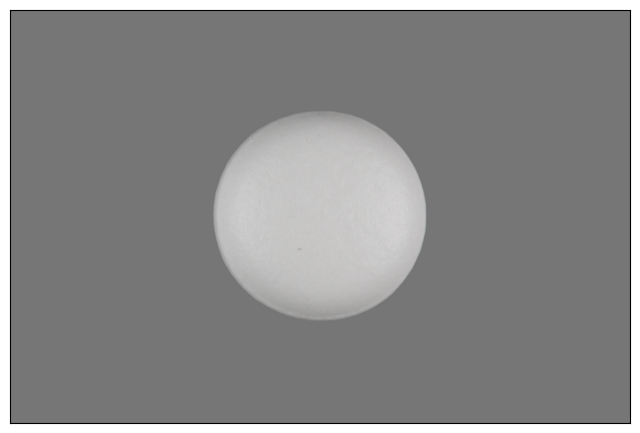

In [13]:
response = lmm.complete(prompt = CAPTION_EXTRACTION_PROMPT, image_documents = [sample_docs[0]])

print(response.text)
print()
print(master_metadata[sample_images[0]]["metadata"])
plot_images([sample_docs[0]])

Image features of the pill:
- Shape: CAPSULE - The pill has the shape of a capsule, which is elongated with rounded ends.
- Color: ORANGE
- Imprint: barr;936
- Imprint Color: BROWN
- Imprint Type: PRINTED - The imprint is printed onto the surface of the pill.
- Score: Pill is not scored to break into smaller dosage parts.
- Other visual features: N/A

{'Shape': 'CAPSULE', 'Color': 'ORANGE', 'Imprint': 'barr;936', 'ImprintColor': 'BLACK', 'ImprintType': 'PRINTED', 'Score': '1'}


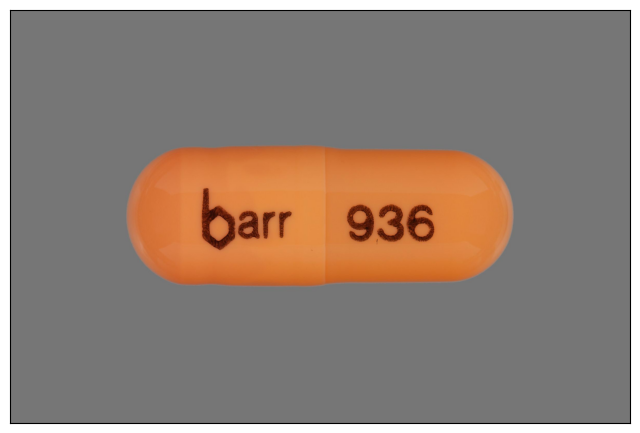

In [14]:
response = lmm.complete(prompt = CAPTION_EXTRACTION_PROMPT, image_documents = [sample_docs[1]])

print(response.text)
print()
print(master_metadata[sample_images[1]]["metadata"])
plot_images([sample_docs[1]])

## Few-shot prompt

In [15]:
lmm = OpenAIMultiModal(model= "gpt-4-vision-preview", temperature=0, max_new_tokens=256, image_detail="high", max_retries=3)

In [16]:
SYSTEM_PROMPT = (
    "You are given an image of a pill. Extract the relevant visual features from the given image,"
    "including shape, colors, imprint, imprint color, symbols, if any and whether the pill can be broken down into smaller parts.\n"
    "=====\n"
    "OUTPUT INSTRUCTIONS: Each line of the final output should contain description about an individual visual feature of the pill. If the visual characteristics cannot be inferred from the image, return N/A for that features\n"
    )

EXAMPLES = [
     {
         "image_file": "PillProjectDisc37/images/BK0UDTM343KHX1I-ANSI_RI-DR_U_6I.JPG",
         "image_content": (
             "Image features of the pill:\n"
             "- Shape: ROUND - The pill has a circular shape when viewed from above\n"
             "- Color: WHITE\n"
             "- Imprint: N/A\n"
             "- Imprint Color: N/A\n"
             "- Imprint Type: N/A\n"
             "- Score: N/A - There is no visible score line indicating the pill can be broken into smaller parts.\n"
             "- Other visual symbols: N/A\n"
         )
     },
     {
         "image_file": "PillProjectDisc110/images/_CNSLF343EJTA_F25S1SJG9-EIKPQ7.JPG",
         "image_content": (
             "Image features of the pill:\n"
             "- Shape: CAPSULE - Has the shape of a capsule when viewing the capsule from a point perpendicular to its longest side."
             "- Color: ORANGE"
             "- Imprint: barr;936"
             "- Imprint Color: BROWN"
             "- Imprint Type: PRINTED - Imprint is printed onto the surface of the pill"
             "- Score: Pill is not scored to break into smaller dosage parts"
             "- Other visual symbols: N/A"
         )
     }
 ]

EXAMPLE_PROMPT = "=====\nEXAMPLE:\n"
QUERY_PROMPT = "=====\nReturn the visual features of this pill"
# EXAMPLES = []

In [17]:
## Few-shot prompt
def generate_llamaindex_chat_messages(
    query_file_path: str,
    system_prompt: str = SYSTEM_PROMPT,
    examples: Optional[List[Dict]] = None,
    image_detail: Literal["high", "low"] = "high",
    resize: Optional[Union[int, Tuple[int, int], Literal["auto"]]] = None
):

    message_dicts = [
        {"prompt": system_prompt, "role": "system", "image_documents": None}
        ]

    for example in examples:
        image_file, image_content = example["image_file"], example["image_content"]
        sample_paths = [os.path.join(REFERENCE_DIR, image_file)]
        example_images = SimpleDirectoryReader(input_files = sample_paths).load_data()
        example_prompt = EXAMPLE_PROMPT + image_content + "\n"
        message_dicts.append({"prompt": example_prompt, "role": "system", "image_documents": example_images})

    query_images = SimpleDirectoryReader(input_files = [query_file_path]).load_data()

    message_dicts.append({"prompt": QUERY_PROMPT, "role": "user", "image_documents": query_images})

    message_list = [
        generate_openai_vision_llamaindex_chat_message(
            prompt=message_dict["prompt"],
            role=message_dict["role"],
            image_documents=message_dict["image_documents"],
            image_detail=image_detail,
            resize=resize
            )
        for message_dict in message_dicts
    ]

    return message_list

### Sequential

In [ ]:
resize = 1024
image_detail = "high"

run_description = "reference_1-1000"
save_folder = os.path.join(ARTIFACT_DIR, run_description)
if not os.path.exists(save_folder):
    os.makedirs(save_folder, exist_ok=True)

In [ ]:
start = time()

chat_responses = []

for idx, image in enumerate(tqdm(consumer_images)):
    try:
        query_path = os.path.join(CONSUMER_DIR, image)
        message_list = generate_llamaindex_chat_messages(
            query_path, system_prompt = SYSTEM_PROMPT, examples = None,
            image_detail = image_detail, resize = resize
        )
        chat_response = lmm.chat(message_list)
        chat_responses.append(chat_response.message.content)
    except Exception as e:
        print(f"Image {image} gets exception {e}")
        chat_responses.append(None)

print(time() - start)

### Asynchronous

In [52]:
RESIZE = 1024
IMAGE_DETAIL = "high"

BATCH_SIZE = 50
SAMPLE_NO = None
CHECKPOINT = None

QUERY_IMAGES = reference_images
QUERY_FOLDER = REFERENCE_DIR
total_sample_no = len(QUERY_IMAGES) 

run_description = "reference_1-1000"
save_folder = os.path.join(ARTIFACT_DIR, run_description)
if not os.path.exists(save_folder):
    os.makedirs(save_folder, exist_ok=True)

In [46]:
if CHECKPOINT:
    chat_responses = load_checkpoint(CHECKPOINT)
    start_idx = start_idx = int(CHECKPOINT.split("/")[-2])
    end_idx = start_idx + SAMPLE_NO if SAMPLE_NO else total_sample_no
    if end_idx > total_sample_no:
        end_idx = total_sample_no
else:
    chat_responses = []
    start_idx = 0
    end_idx = start_idx + SAMPLE_NO if SAMPLE_NO else total_sample_no
    
print(start_idx, end_idx)

0 10


In [55]:
istart = time()

chat_responses = []

for start_batch_idx in tqdm(range(start_idx, end_idx, BATCH_SIZE)):
    end_batch_idx = start_batch_idx + BATCH_SIZE if start_batch_idx + BATCH_SIZE < total_sample_no \
                    else total_sample_no

    batch_responses = []
    for image in QUERY_IMAGES[start_batch_idx:end_batch_idx]:
        # try:
        query_path = os.path.join(QUERY_FOLDER, image)
        print(query_path)
        message_list = generate_llamaindex_chat_messages(
            query_path, system_prompt = SYSTEM_PROMPT, examples = EXAMPLES,
            image_detail = image_detail, resize = resize
        )
        chat_response = lmm.achat(message_list)
        batch_responses.append(chat_response)
        # except Exception as e:
        #     print(f"Image {image} gets exception {e}")
        #     batch_responses.append(None)

    batch_responses = await asyncio.gather(*batch_responses, return_exceptions=True)
    for idx, response in enumerate(batch_responses):
        if not isinstance(response, ChatResponse):
            batch_responses[idx] = None
            print(f"Unable to process image with idx: {start_batch_idx + idx}")
        else:
            batch_responses[idx] = response.message.content
            
    chat_responses.extend(batch_responses)
    assert len(chat_responses) == end_batch_idx
    ckpt_folder = os.path.join(save_folder, "checkpoint", str(end_batch_idx))
    save_checkpoint(ckpt_folder, QUERY_IMAGES[:end_batch_idx], chat_responses)
    print("Successfully saved checkpoint at folder:", ckpt_folder)  

  0%|          | 0/5 [00:00<?, ?it/s]

/mnt/c/Users/QUAN/Desktop/pill/data/reference/PillProjectDisc37/images/BKMNRTQ6_7JVE3M5_DIU81YSSX!P!HB.JPG
/mnt/c/Users/QUAN/Desktop/pill/data/reference/PillProjectDisc43/images/BPJHG_K6IRN91BK5G444NFL92U9_AG5.JPG


 20%|██        | 1/5 [00:11<00:47, 11.93s/it]

Successfully saved checkpoint at folder: /mnt/c/Users/QUAN/Desktop/pill/artifacts/reference_1-1000/checkpoint/2
/mnt/c/Users/QUAN/Desktop/pill/data/reference/PillProjectDisc106/images/W9WJ5DVPKN8-DARNMB53SKVF8PU!2N.JPG
/mnt/c/Users/QUAN/Desktop/pill/data/reference/PillProjectDisc12/images/8LL0A9QTPOWC-E77KNDMUSYD6EQH-S.JPG


 40%|████      | 2/5 [00:17<00:25,  8.48s/it]

Successfully saved checkpoint at folder: /mnt/c/Users/QUAN/Desktop/pill/artifacts/reference_1-1000/checkpoint/4
/mnt/c/Users/QUAN/Desktop/pill/data/reference/PillProjectDisc27/images/BAW7MVDATQZJSPKO-DZI0H3-17GX85O.JPG
/mnt/c/Users/QUAN/Desktop/pill/data/reference/PillProjectDisc16/images/B0S!Y9V2RF6O-4DKUSZ4U11GDZTAFK7.JPG


 60%|██████    | 3/5 [00:26<00:16,  8.47s/it]

Successfully saved checkpoint at folder: /mnt/c/Users/QUAN/Desktop/pill/artifacts/reference_1-1000/checkpoint/6
/mnt/c/Users/QUAN/Desktop/pill/data/reference/PillProjectDisc44/images/BR68IW9SWHRFU8DZXBCF77ZK9UHGE3I.JPG
/mnt/c/Users/QUAN/Desktop/pill/data/reference/PillProjectDisc26/images/BA4!2HLRJX4CXD2!IEC9EG12Y6WY1HE.JPG


 80%|████████  | 4/5 [00:34<00:08,  8.47s/it]

Successfully saved checkpoint at folder: /mnt/c/Users/QUAN/Desktop/pill/artifacts/reference_1-1000/checkpoint/8
/mnt/c/Users/QUAN/Desktop/pill/data/reference/PillProjectDisc102/images/TEFMMBHUNS-95!CV7S8DY34PO5RY!B.JPG
/mnt/c/Users/QUAN/Desktop/pill/data/reference/PillProjectDisc58/images/CBMP0-36ND13BX_VZB5HWB72BHZ7-R7.JPG


100%|██████████| 5/5 [00:45<00:00,  9.05s/it]

Successfully saved checkpoint at folder: /mnt/c/Users/QUAN/Desktop/pill/artifacts/reference_1-1000/checkpoint/10


In [210]:


for image in consumer_images[:10]:
    try:
        query_path = os.path.join(CONSUMER_DIR, image)
        print(query_path)
        message_list = generate_llamaindex_chat_messages(
            query_path, system_prompt = SYSTEM_PROMPT, examples = None,
            image_detail = image_detail, resize = resize
        )
        chat_response = lmm.achat(message_list)
        chat_responses.append(chat_response)
    except Exception as e:
        print(f"Image {image} gets exception {e}")
        chat_responses.append(None)

chat_responses = await asyncio.gather(*chat_responses, return_exceptions=True)

/content/drive/MyDrive/LLM/data/pill/consumer/PillProjectDisc21/images/B5T5HI5XI8X2HSBJL-TGDHET4YG5C5F.JPG
/content/drive/MyDrive/LLM/data/pill/consumer/PillProjectDisc92/images/K6QQET!08476TI3778Y4EJ3ILMZ!CR.JPG
/content/drive/MyDrive/LLM/data/pill/consumer/PillProjectDisc35/images/BINZI-PDPZ36VT4NFBE_5CNNF6N3676.JPG
/content/drive/MyDrive/LLM/data/pill/consumer/PillProjectDisc106/images/WGK1UE6H7T-EARPNYO4LB09!T_VF9_.JPG
/content/drive/MyDrive/LLM/data/pill/consumer/PillProjectDisc2/images/-CYJI2!27!DZ9MOE83-5K-54DDSKRY.JPG
/content/drive/MyDrive/LLM/data/pill/consumer/PillProjectDisc40/images/BNH0_FQ-T4G9AL_H45VENPU7LK-!GH_.JPG
/content/drive/MyDrive/LLM/data/pill/consumer/PillProjectDisc17/images/B1ZEV_ZLK!76VL9N6!Y3D2G70NOECMX.JPG
/content/drive/MyDrive/LLM/data/pill/consumer/PillProjectDisc13/images/9_KKSUTJTJXL5UO4_-Z6F3H51RIRO4.JPG
/content/drive/MyDrive/LLM/data/pill/consumer/PillProjectDisc102/images/SRWU_F3Z088KVB4QZ4XMC_SMD5HJP0.JPG
/content/drive/MyDrive/LLM/data/pill/cons